## MALL DATA CLUSTERING PROJECT

### DATA EXPLORING AND PREPROCESSING

In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import statistics as st
import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing data
df = pd.read_csv("mall.csv")
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
#checking size
df.shape

(200, 5)

In [4]:
#data types
df.dtypes

CustomerID                 int64
Genre                     object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [5]:
# column names
df.columns

Index(['CustomerID', 'Genre', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

In [6]:
# checking for nulls
df.isnull().sum()

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [7]:
# checking for duplicates
df.duplicated().sum()

0

In [8]:
#value counts of genre
df.Genre.value_counts()

Female    112
Male       88
Name: Genre, dtype: int64

In [9]:
df.rename(columns={'Annual Income (k$)':'Annual Income $','Spending Score (1-100)':'Spending Score'},inplace=True)

### EXPLORATORY DATA ANALYSIS

In [10]:
# pie chart
def pie(df, col):
    plt.subplots(figsize = (10,5), dpi = 100)
    colors = sns.color_palette('Set2')
    percentage = df[col].value_counts()
    labels = list(df[col].value_counts().index)
    plt.pie(percentage,labels = labels, autopct= "%0.2f%%", colors = colors,explode=[0.05,0.0])
    plt.title(col)

In [11]:
# box plot
def box_bivariate(df,col1,col2,color):
    plt.figure(figsize=(10,5))
    sns.boxplot(data=df,x = col1,y = col2,palette=color)
    plt.title(f'{col2,col1} Distribution')

#### Gender Ratio

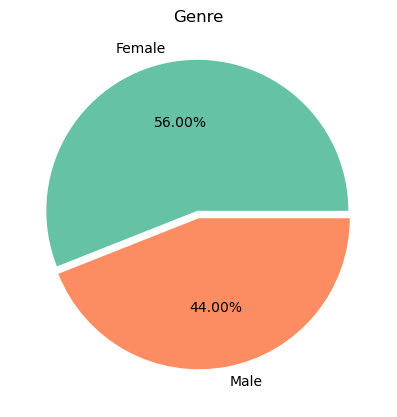

In [12]:
pie(df,"Genre")

around 56 % of the customers are females

#### Gender wise Age

#### Age - Gender

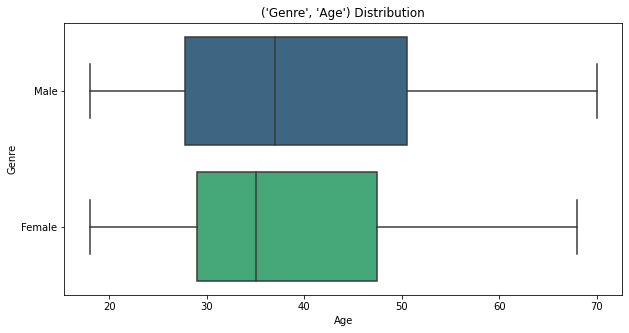

In [13]:
box_bivariate(df,"Age","Genre","viridis")

Average female age is around 35 and male is around 37

#### Income - Gender

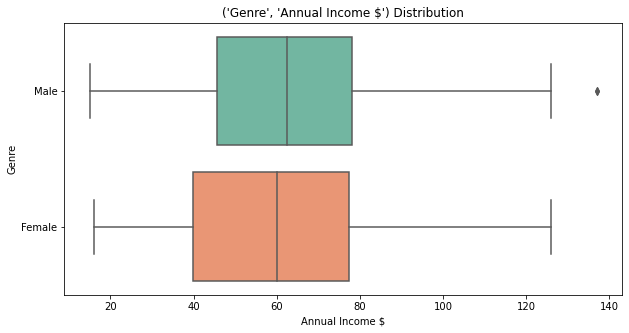

In [14]:
box_bivariate(df,"Annual Income $","Genre","Set2")

Both males and females have an average income of 60k

#### Spending score - Gender

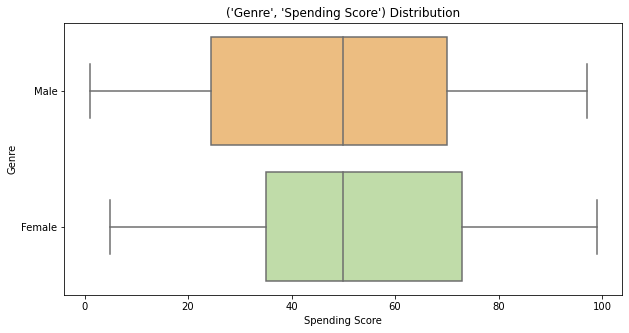

In [15]:
box_bivariate(df,"Spending Score","Genre","Spectral")

females considerably have more spending score

#### Age - Income

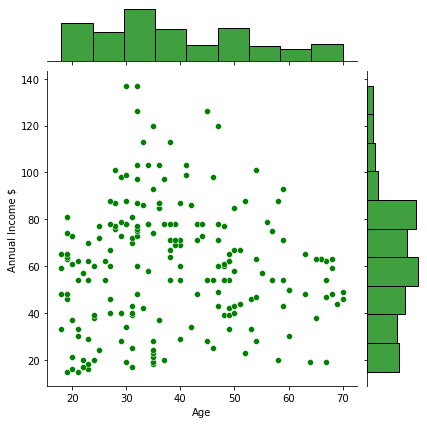

In [16]:
sns.jointplot(data= df, x= 'Age', y= 'Annual Income $',color='green');

people below 35 earn less

#### Age - Spending score

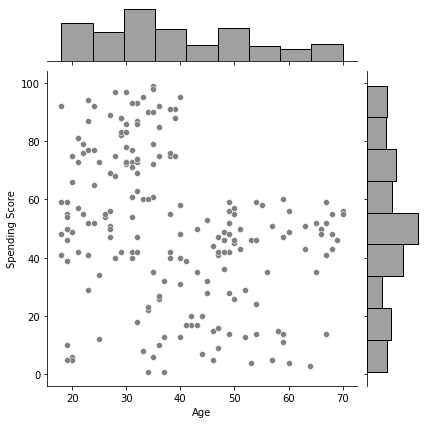

In [17]:
sns.jointplot(data= df, x= 'Age', y= 'Spending Score',color='gray');

people below the age of 35 tend to spend more

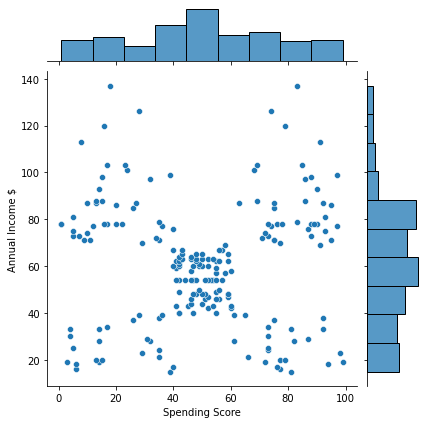

In [18]:
sns.jointplot(data= df, y= 'Annual Income $', x= 'Spending Score');

most of the people have a spending score between 40 - 60

### DUMMY ENCODING

In [19]:
# dropping unecessary columns
df.drop(columns=['CustomerID'],inplace=True)

In [20]:
df.shape

(200, 4)

In [21]:
#Encoding Gender
Gender_dummies = pd.get_dummies(df.Genre, prefix="Genre",drop_first=True)
df_with_dummies = pd.concat([df,Gender_dummies],axis='columns')
df_with_dummies.drop('Genre',axis='columns',inplace=True)

In [22]:
df_with_dummies.head()

,Age,Annual Income $,Spending Score,Genre_Male
0,19,15,39,1
1,21,15,81,1
2,20,16,6,0
3,23,16,77,0
4,31,17,40,0


### K MEANS CLUSTERING

In [23]:
mall_df = df_with_dummies

In [24]:
from sklearn.cluster import DBSCAN, KMeans,AgglomerativeClustering

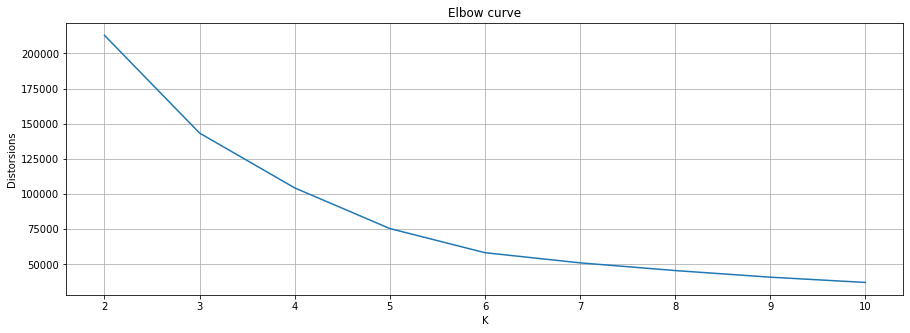

In [25]:
distorsions = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(mall_df)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 11), distorsions)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Distorsions')
plt.title('Elbow curve');

In [26]:
def sil_score(df,model_name):
    from sklearn.metrics import silhouette_samples, silhouette_score
    import matplotlib.cm as cm

    range_n_clusters = [2, 3, 4, 5, 6, 7]

    for n_clusters in range_n_clusters:
        fig, ax1 = plt.subplots(1, 1)
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
        if model_name == 'kmeans':
            clusterer = KMeans(n_clusters=n_clusters, random_state=10)
            cluster_labels = clusterer.fit_predict(df)
            silhouette_avg = silhouette_score(df, cluster_labels)
            print("For n_clusters =", n_clusters,
              "The average silhouette_score for kmeans is :", silhouette_avg)
            sample_silhouette_values = silhouette_samples(df, cluster_labels)
            y_lower = 10
        elif model_name == 'agglo':
            clusterer = AgglomerativeClustering(n_clusters = n_clusters, affinity = 'euclidean', linkage = 'ward')
            cluster_labels = clusterer.fit_predict(df)
            silhouette_avg = silhouette_score(df, cluster_labels)
            print("For n_clusters =", n_clusters,
              "The average silhouette_score for agglo is :", silhouette_avg)
            sample_silhouette_values = silhouette_samples(df, cluster_labels)
            y_lower = 10
    
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10  
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_title(f'Cluster {n_clusters}')
        ax1.set_yticks([]) 
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

For n_clusters = 2 The average silhouette_score for kmeans is : 0.29307334005502633
For n_clusters = 3 The average silhouette_score for kmeans is : 0.383798873822341
For n_clusters = 4 The average silhouette_score for kmeans is : 0.4052954330641215
For n_clusters = 5 The average silhouette_score for kmeans is : 0.4440669204743008
For n_clusters = 6 The average silhouette_score for kmeans is : 0.45205475380756527
For n_clusters = 7 The average silhouette_score for kmeans is : 0.43949619264530887


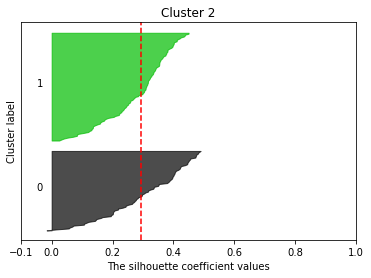

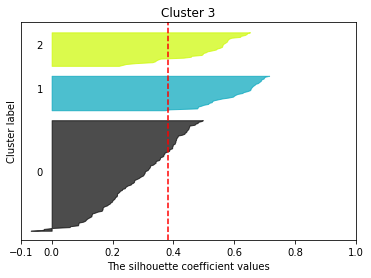

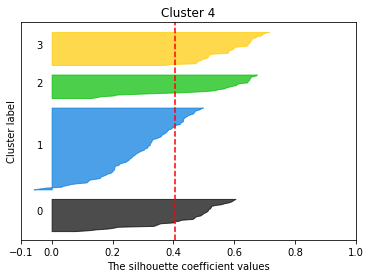

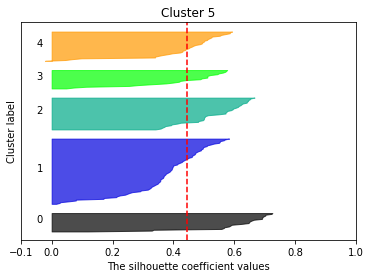

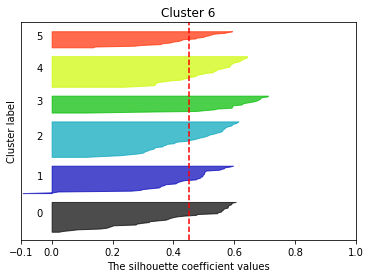

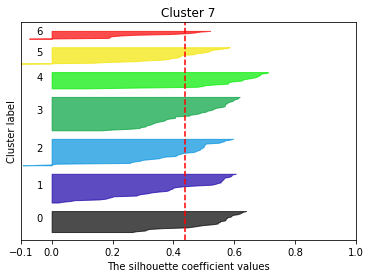

In [27]:
sil_score(mall_df,'kmeans')

In [28]:
Kmeans_model = KMeans(n_clusters=5).fit(mall_df)

In [29]:
cluster_centroid = Kmeans_model.cluster_centers_
cluster_centroid

array([[40.66666667, 87.75      , 17.58333333,  0.52777778],
       [42.9375    , 55.0875    , 49.7125    ,  0.4125    ],
       [32.69230769, 86.53846154, 82.12820513,  0.46153846],
       [25.27272727, 25.72727273, 79.36363636,  0.40909091],
       [45.2173913 , 26.30434783, 20.91304348,  0.39130435]])

In [30]:
labels1 = Kmeans_model.labels_
labels1

array([4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 1,
       4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 1, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 1, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 2])

In [31]:
mall_df['Kmeans_labels']=labels1
mall_df['Kmeans_labels'].value_counts()

1    80
2    39
0    36
4    23
3    22
Name: Kmeans_labels, dtype: int64

In [32]:
import matplotlib
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score
def scatter(df,col1,col2,col3,model_name):
    label_name = [i for i in df[col3].unique()]
    colors=['purple','red','blue','green','orange','magenta']
    plt.figure(figsize=(10,6))
    plt.scatter(df[col1], df[col2], c=df[col3],cmap=matplotlib.colors.ListedColormap(colors),s=25)
    plt.xlabel(col1)
    plt.ylabel(col2)
    result = plt.scatter(df[col1], df[col2], c=df[col3],cmap=matplotlib.colors.ListedColormap(colors),s=25)
    plt.legend(handles=result.legend_elements()[0], 
       labels=label_name,
       title="Label Class")
    plt.title(model_name)
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(df, df[col3]))
    print("DB index: %0.3f" % davies_bouldin_score(df, df[col3]))
    print("CH index: %0.3f" % metrics.calinski_harabasz_score(df, df[col3]))


Silhouette Coefficient: 0.445
DB index: 0.818
CH index: 151.108


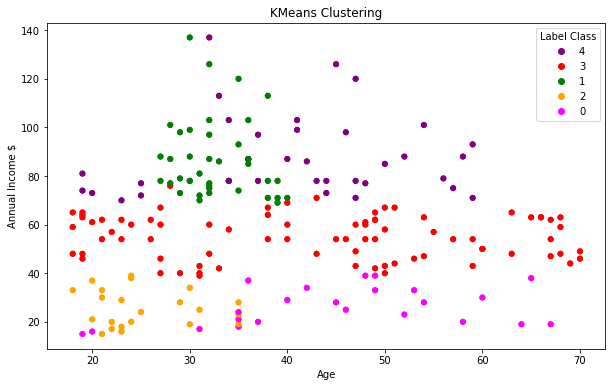

In [33]:
scatter(mall_df,'Age','Annual Income $','Kmeans_labels','KMeans Clustering')

Silhouette Coefficient: 0.445
DB index: 0.818
CH index: 151.108


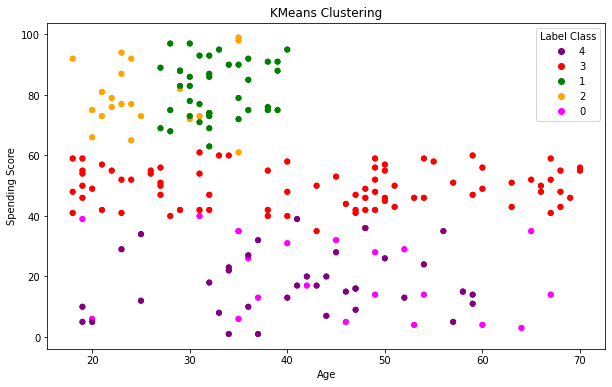

In [34]:
scatter(mall_df,'Age','Spending Score','Kmeans_labels','KMeans Clustering')

Silhouette Coefficient: 0.445
DB index: 0.818
CH index: 151.108


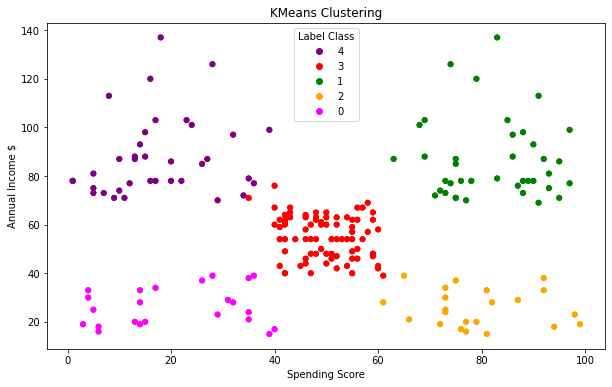

In [35]:
scatter(mall_df,'Spending Score','Annual Income $','Kmeans_labels','KMeans Clustering')

### HIERARCHIAL AGGLO CLUSTERING

In [36]:
mall_df2 = df_with_dummies

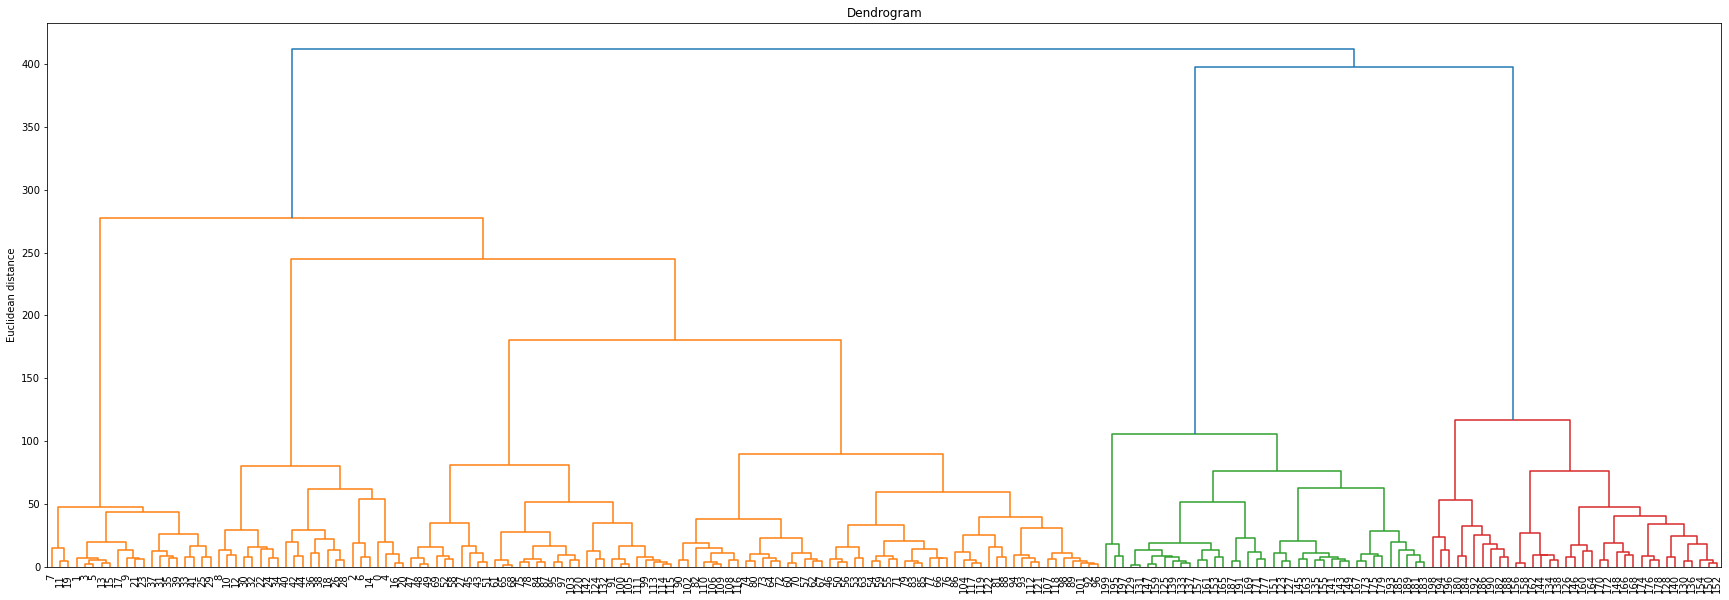

In [37]:
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(30,10))
dend = sch.dendrogram(sch.linkage(mall_df2, method='ward'), labels=mall_df2.index)
ax = plt.gca() 
ax.tick_params(axis='x', which ='major', labelsize=10)
plt.title('Dendrogram')
plt.ylabel('Euclidean distance')
plt.show()

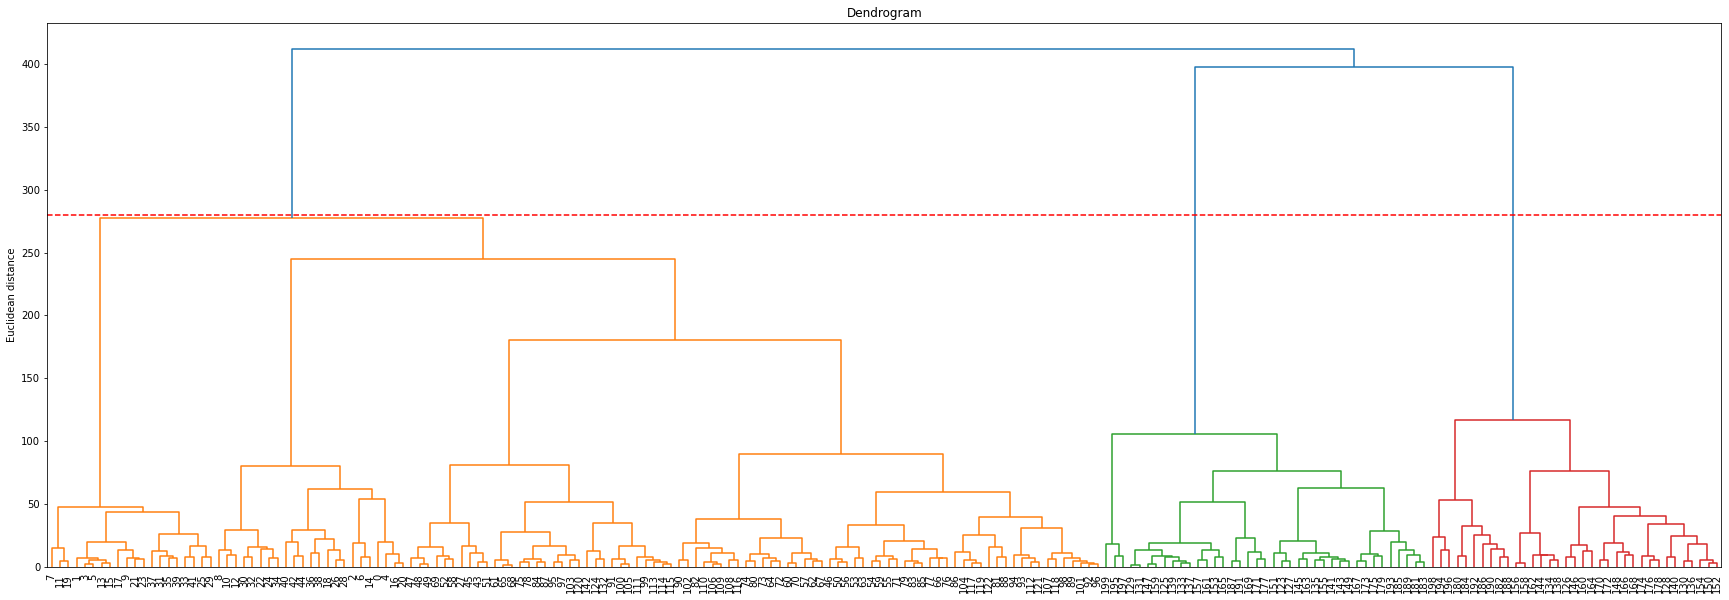

In [38]:
plt.figure(figsize=(30,10))
dend = sch.dendrogram(sch.linkage(mall_df2, method='ward'), labels=mall_df2.index)
plt.axhline(y=280,color='r',linestyle='--')
ax = plt.gca() 
ax.tick_params(axis='x', which ='major', labelsize=10)
plt.title('Dendrogram')
plt.ylabel('Euclidean distance')
plt.show()

For n_clusters = 2 The average silhouette_score for agglo is : 0.29898018713629965
For n_clusters = 3 The average silhouette_score for agglo is : 0.38119124265214327
For n_clusters = 4 The average silhouette_score for agglo is : 0.4102058345861351
For n_clusters = 5 The average silhouette_score for agglo is : 0.4405759066133614
For n_clusters = 6 The average silhouette_score for agglo is : 0.4431245097739428
For n_clusters = 7 The average silhouette_score for agglo is : 0.4262499443680674


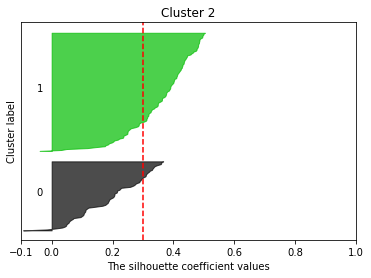

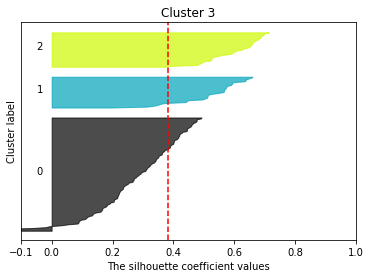

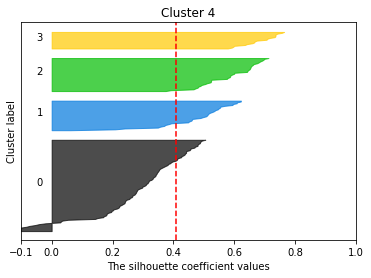

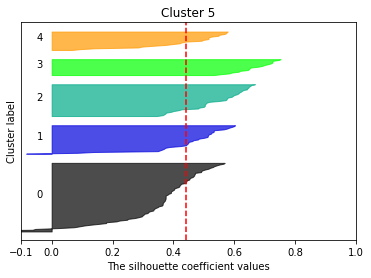

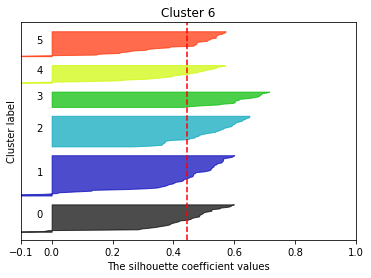

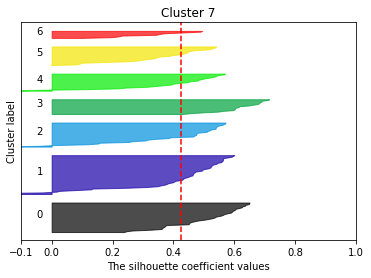

In [39]:
sil_score(mall_df2,'agglo')

In [40]:
agglo_model = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward')

In [41]:
labels2 = agglo_model.fit_predict(mall_df2)
labels2

array([4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 0, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 0,
       4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 1, 2, 1, 2, 1, 2,
       0, 2, 1, 2, 1, 2, 1, 2, 1, 2, 0, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
       1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
       1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
       1, 2], dtype=int64)

In [42]:
mall_df2['agglo_labels']=labels2
mall_df2['agglo_labels'].value_counts()

0    83
2    39
1    35
4    23
3    20
Name: agglo_labels, dtype: int64

Silhouette Coefficient: 0.442
DB index: 0.819
CH index: 147.991


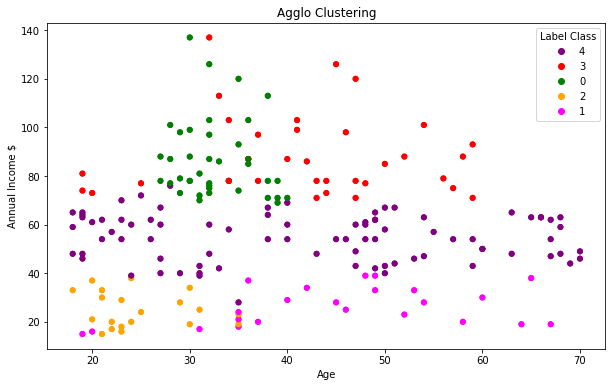

In [43]:
scatter(mall_df2,'Age','Annual Income $','agglo_labels','Agglo Clustering')

Silhouette Coefficient: 0.442
DB index: 0.819
CH index: 147.991


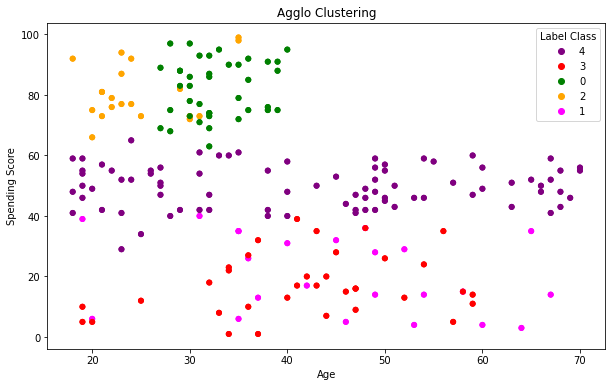

In [44]:
scatter(mall_df2,'Age','Spending Score','agglo_labels','Agglo Clustering')

Silhouette Coefficient: 0.442
DB index: 0.819
CH index: 147.991


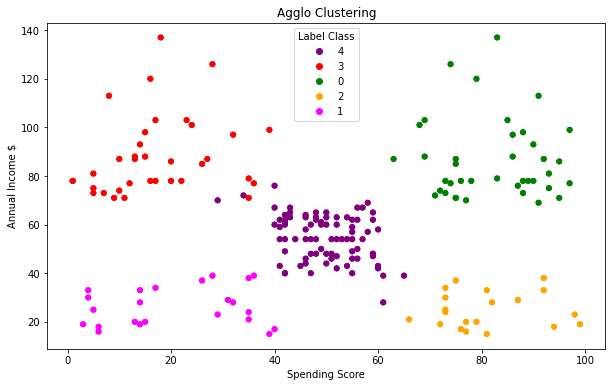

In [45]:
scatter(mall_df2,'Spending Score','Annual Income $','agglo_labels','Agglo Clustering')

### DBSCAN CLUSTERING

In [46]:
mall_df3 = df_with_dummies

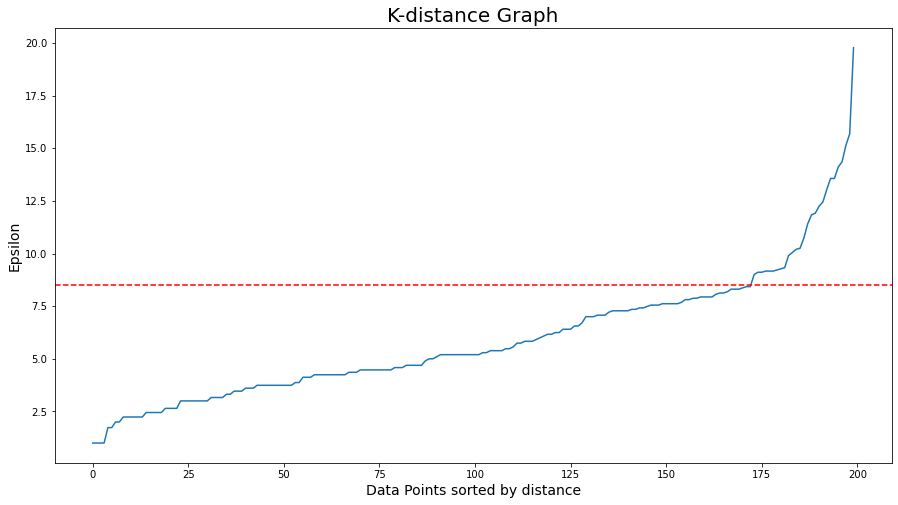

In [47]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(mall_df3)
distances, indices = nbrs.kneighbors(mall_df3)
dist = np.sort(distances,axis=0)
dist1 = dist[:,1]
plt.figure(figsize=(15,8))
plt.plot(dist1)
plt.axhline(y=8.5,color='red',linestyle='--')
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

eps = 8.5

In [48]:
for min_samples in [2,3,4,5,6,7,8,9]:
    clusterer = DBSCAN(eps=8.5, min_samples=min_samples)
    cluster_labels = clusterer.fit_predict(mall_df3)

    x= cluster_labels +2
    y = np.bincount(x)
    # print((np.nonzero(y)[0]))
    ii = np.nonzero(y)[0]
    results = list(zip(ii,y[ii]) )
    print('eps=',0.45,'| min_samples= ', min_samples, '| obtained clustering: ', results)

eps= 0.45 | min_samples=  2 | obtained clustering:  [(1, 27), (2, 15), (3, 5), (4, 2), (5, 2), (6, 3), (7, 2), (8, 47), (9, 9), (10, 19), (11, 7), (12, 2), (13, 3), (14, 30), (15, 2), (16, 2), (17, 4), (18, 6), (19, 2), (20, 3), (21, 2), (22, 2), (23, 2), (24, 2)]
eps= 0.45 | min_samples=  3 | obtained clustering:  [(1, 49), (2, 15), (3, 5), (4, 3), (5, 47), (6, 9), (7, 19), (8, 7), (9, 30), (10, 3), (11, 4), (12, 6), (13, 3)]
eps= 0.45 | min_samples=  4 | obtained clustering:  [(1, 77), (2, 9), (3, 4), (4, 9), (5, 32), (6, 12), (7, 19), (8, 7), (9, 27), (10, 4)]
eps= 0.45 | min_samples=  5 | obtained clustering:  [(1, 98), (2, 9), (3, 30), (4, 12), (5, 18), (6, 7), (7, 22), (8, 4)]
eps= 0.45 | min_samples=  6 | obtained clustering:  [(1, 108), (2, 9), (3, 25), (4, 12), (5, 18), (6, 6), (7, 12), (8, 10)]
eps= 0.45 | min_samples=  7 | obtained clustering:  [(1, 123), (2, 9), (3, 10), (4, 18), (5, 18), (6, 12), (7, 10)]
eps= 0.45 | min_samples=  8 | obtained clustering:  [(1, 140), (2, 8

min_samples=  9

In [49]:
dbscan = DBSCAN(eps=8.5,min_samples=9)

In [50]:
labels3 = dbscan.fit_predict(mall_df3)
labels3 

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1,  0, -1, -1, -1,  1,  0,  0,  1,  0, -1, -1, -1,  0,  1,
        0, -1,  1, -1,  0, -1,  1,  0,  0, -1,  1,  0,  1,  0,  1, -1,  0,
       -1,  1,  0,  1, -1,  0, -1, -1, -1,  1, -1,  1,  1,  1, -1, -1,  0,
       -1, -1, -1, -1, -1, -1,  2, -1, -1, -1,  2, -1,  2, -1,  2, -1, -1,
       -1,  2, -1,  2, -1, -1, -1, -1, -1, -1, -1,  2, -1, -1, -1, -1, -1,
        2, -1, -1, -1,  2, -1,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=int64)

In [51]:
mall_df3['dbscan_labels']=labels3
mall_df3['dbscan_labels'].value_counts()

-1    161
 0     15
 1     14
 2     10
Name: dbscan_labels, dtype: int64

Silhouette Coefficient: -0.207
DB index: 3.719
CH index: 3.143


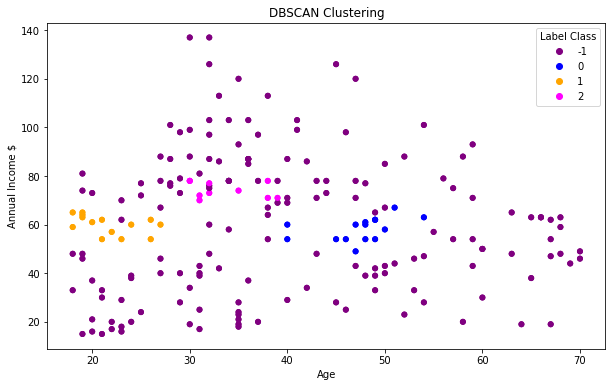

In [52]:
scatter(mall_df3,'Age','Annual Income $','dbscan_labels','DBSCAN Clustering')

Silhouette Coefficient: -0.207
DB index: 3.719
CH index: 3.143


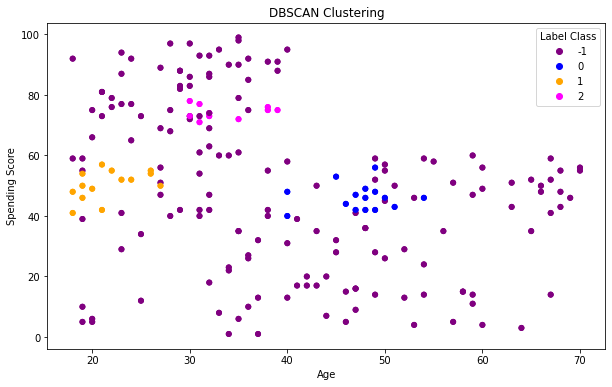

In [53]:
scatter(mall_df3,'Age','Spending Score','dbscan_labels','DBSCAN Clustering')

Silhouette Coefficient: -0.207
DB index: 3.719
CH index: 3.143


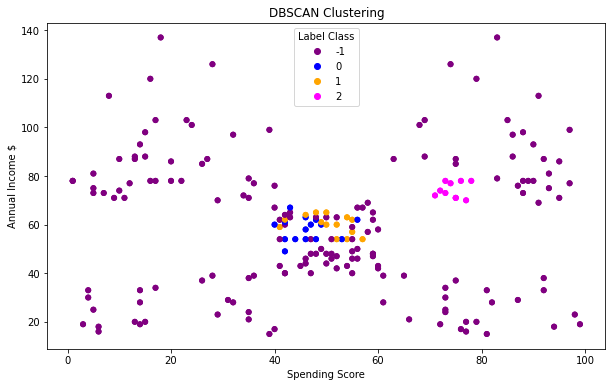

In [54]:
scatter(mall_df3,'Spending Score','Annual Income $','dbscan_labels','DBSCAN Clustering')

#### IDEAL CUSTOMERS

In [55]:
df_ideal = df[(df['Genre']=='Female') & (df['Spending Score']>65) &(df['Age']>=30)&(df['Age']<=40)&(df['Annual Income $']>75)]

In [56]:
df_ideal

,Genre,Age,Annual Income $,Spending Score
143,Female,32,76,87
147,Female,32,77,74
153,Female,38,78,76
157,Female,30,78,78
159,Female,30,78,73
163,Female,31,81,93
165,Female,36,85,75
167,Female,33,86,95
175,Female,30,88,86
181,Female,32,97,86
